# Noise Learning Testing
This notebook is for verifying the procedure's ability to learn a noise model in ideal conditions. A simulated Pauli noise model is used with no readout error. The measurements that are made as part of the procedure can be classified into two groups: The spam-free fidelity-pair measurements that are determined by exponential fits at multiple depths, and the degeneracy-lifting measurements made at a single depth. The results of both of these types of measurements are plotted against the known values from the generated noise model. The full list of resulting fidelities is shown against the ideal values, along with the measured coefficients in the noise generator.

In [61]:
from qiskit import QuantumCircuit, Aer
from qiskit.quantum_info import pauli_basis, Pauli, PTM, SuperOp
from qiskit.providers.aer.noise import NoiseModel, pauli_error, amplitude_damping_error
from qiskit.providers.fake_provider import FakeVigoV2
from random import random, choices
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import nnls

import sys

sys.path.append("../pauli_lindblad_per")
from tomography.experiment import SparsePauliTomographyExperiment as tomography

plt.style.use("ggplot")

## Generating a random Pauli + Amplitude damping noise model
For simplicity, this benchmark of the protocol uses a randomly generated Pauli channel. The descrepencies in the learned fidelities vs the simulated noise model are easier to see if there is more variation in the Pauli fidelities. Choosing a smaller subset of Pauli errors to simulate helps cause there to be bigger distances in between the different fidelities, as can be seen in the graph below.

In [62]:
num = 4 #Number of errors to simulate. Decreasing this number produces more widely
        #varying fidelities, which is better for benchmarking the model

amp_damp = amplitude_damping_error(.01, .1)

errorops = choices(pauli_basis(2), k=num) #choose random pauli errors
errorprobs = [random()*.1/num for op in errorops] #assign random probabilities

#create normalized error model
twoqubit_error = pauli_error([(op, p) for op,p in zip(errorops, errorprobs)]+[(Pauli("II"), 1-sum(errorprobs))])
twoqubit_error = twoqubit_error.compose(amp_damp)
noise_model = NoiseModel()

#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

{'II': -1.3322676295501878e-15, 'IX': 0.060169040827466325, 'IY': 0.09674011766437529, 'IZ': 0.04638776201418404, 'XI': 0.03675531516584296, 'XX': 0.09674011766437529, 'XY': 0.060169040827466325, 'XZ': 0.009999999999999232, 'YI': 0.09481809815341058, 'YX': 0.08755888614305152, 'YY': 0.05098780930614255, 'YZ': 0.06748215515769118, 'ZI': 0.0580627829875664, 'ZX': 0.05098780930614255, 'ZY': 0.08755888614305152, 'ZZ': 0.10386991717187599}


Text(0, 0.5, 'Infidelity')

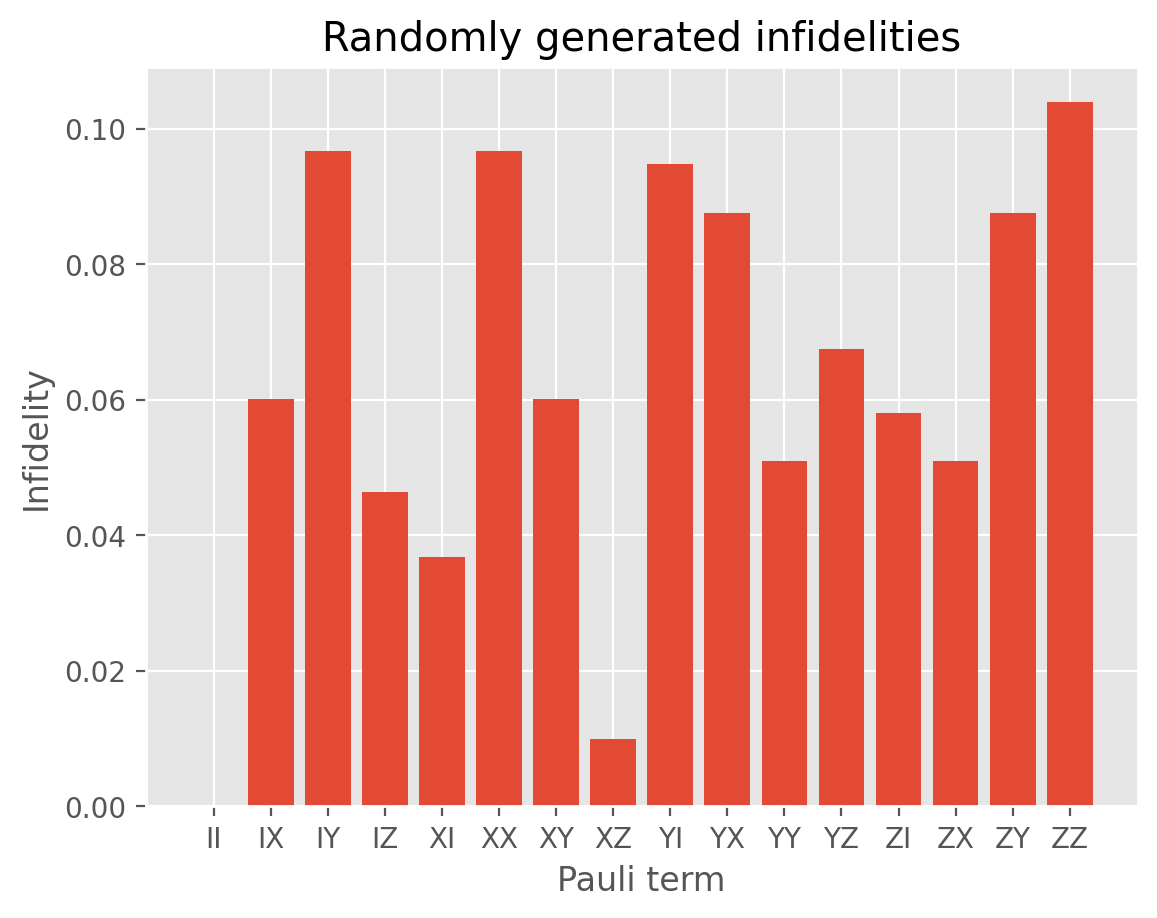

In [63]:
real_errors = {}

n = 2
channel = twoqubit_error.to_quantumchannel().data
twirled_channel = np.zeros([4**n,4**n])

for m in pauli_basis(n):
    p = np.kron(np.conjugate(m.to_matrix()),m.to_matrix())
    twirled_channel = np.add(twirled_channel, 1/4**n * p @ channel @ p)
transfer_matrix = PTM(SuperOp(twirled_channel)).data

real_errors = {p:1-transfer_matrix[i][i].real for i,p in enumerate(pauli_basis(n).to_labels())}
print(real_errors)
paulis = pauli_basis(n).to_labels()
plt.bar(paulis, [real_errors[p] for p in paulis])
plt.title("Randomly generated infidelities")
plt.xlabel("Pauli term")
plt.ylabel("Infidelity")

## Defining a circuit
Define the executor function to simulate the noise channel on the circuits, and create a simple circuit consisting of a single CNOT gate as the test model

In [85]:
def executor(circuits): #define noisy executor
    return Aer.get_backend("qasm_simulator").run(circuits, noise_model = noise_model, shots = 500).result().get_counts()

#Define circuit
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.draw()

#from primitives.circuit import QiskitCircuit
#qc = QiskitCircuit(qc)

q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
q_2: ─────

## Run Experiment
These steps are described in the tutorial notebook. This sets up the tomography experiment, generates the circuits, runs it, analyzes it, and returns the noise model

In [65]:
#set up experiment
experiment = tomography(circuits = [qc], inst_map = [0,1], backend = FakeVigoV2())

#generate circuits
experiment.generate(samples = 32, single_samples = 250, depths = [2,4,8,16])

#run circiuts
experiment.run(executor)

#return noise model
noisedataframe = experiment.analyze()

#get single circuit layer in noise model
layer = experiment.analysis.get_layer_data(0)

In [66]:
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

### Plot fidelity decays

In [67]:
from primitives.pauli import QiskitPauli
labels = [QiskitPauli(l) for l in pauli_basis(2).to_labels()[1:]]

In [68]:
p_set = set()
for l in labels:
    if not layer._term_data[l].pair in p_set:
        p_set.add(l)

In [69]:
p_set

{IX, IY, IZ, XI, XZ, YI, YX, YY, ZI}

Text(0, 0.5, 'f')

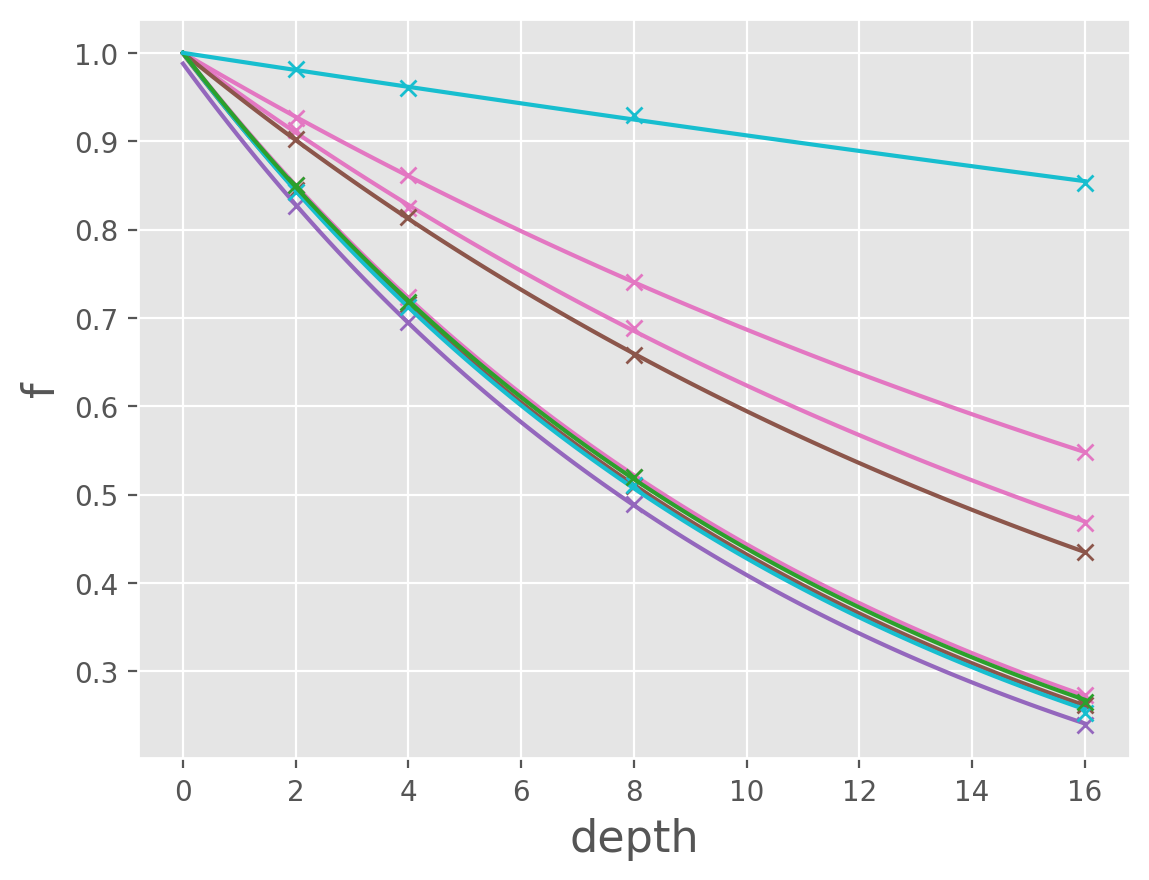

In [70]:
COLORS = [
    "tab:blue", 
    "tab:orange", 
    "tab:green", 
    "tab:red", 
    "tab:purple", 
    "tab:cyan", 
    "tab:brown", 
    "tab:pink", 
    "tab:gray", 
    "tab:olive"
    ]

from itertools import cycle
colcy = cycle(COLORS)
ax = plt.gca()
for p in p_set:
    layer._term_data[p].graph(ax)
plt.xlabel("depth", fontsize = 16)
plt.ylabel("f", fontsize = 16)

In [71]:
fidelities = [(layer._term_data[l].pair_fidelity, layer._term_data[l].pauli, layer._term_data[l].pair) for l in p_set]

In [72]:
low_to_high = sorted(fidelities)

In [73]:
low_to_high

[(0.9156116004656233, YX, ZY),
 (0.9186239307465328, ZI, ZZ),
 (0.9196374673296529, YI, YZ),
 (0.9209687643066656, IY, XY),
 (0.9219676860039591, IX, XX),
 (0.9493178487510889, YY, ZX),
 (0.9538621398939676, IZ, IZ),
 (0.963128673083818, XI, XI),
 (0.9902405481402206, XZ, XZ)]

In [74]:
ps = list(zip(*low_to_high))[1]

In [75]:
labels

[IX, IY, IZ, XI, XX, XY, XZ, YI, YX, YY, YZ, ZI, ZX, ZY, ZZ]

In [76]:
pairs = [Pauli(l.to_label()).evolve(qc) for l in ps]
list(zip(ps, pairs))

[(YX, Pauli('ZY')),
 (ZI, Pauli('ZZ')),
 (YI, Pauli('YZ')),
 (IY, Pauli('XY')),
 (IX, Pauli('XX')),
 (YY, Pauli('-ZX')),
 (IZ, Pauli('IZ')),
 (XI, Pauli('XI')),
 (XZ, Pauli('XZ'))]

## Plot against known noise model

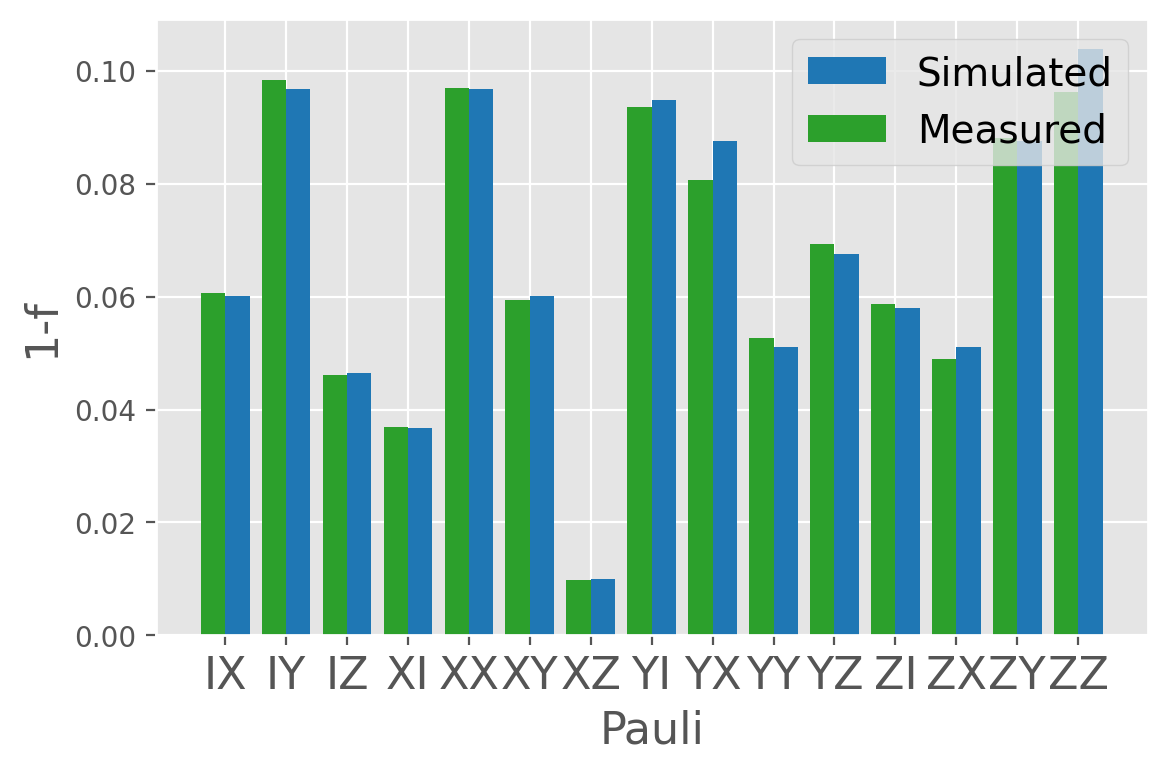

In [77]:
#List out the measured terms and fidelities
in_order = sorted(layer._term_data, key = lambda x: x.to_label())
terms = list([t.to_label() for t in in_order])
fidelities = list([1-layer._term_data[dat].fidelity for dat in in_order])

ax = np.arange(0,len(terms))

#plot them against the corresponding simulated fidelities
plt.figure(figsize=(6.4,4), dpi = 200)
plt.bar(ax+.2, [real_errors[lab] for lab in terms],.4, color='tab:blue')
plt.bar(ax-.2, fidelities, .4, color = 'tab:green')
plt.xticks(ax, terms, fontsize = 16);

#title the graph
plt.xlabel("Pauli", fontsize = 16)
plt.ylabel("1-f", fontsize = 16)
plt.legend(['Simulated', 'Measured'], fontsize = 14)

### Measurement breadown
As discussed in the tutorial, the measurements can be broken down into pair fidelity measurements that are spam-free and degeneracy-lifting measurements that are sensitive to spam noise. The following graphs show a breakdown of the results of these measurements used to fit the model.

#### Pair measurements
The plot below shows the pair measurements compaired with simulated fidelity pairs.

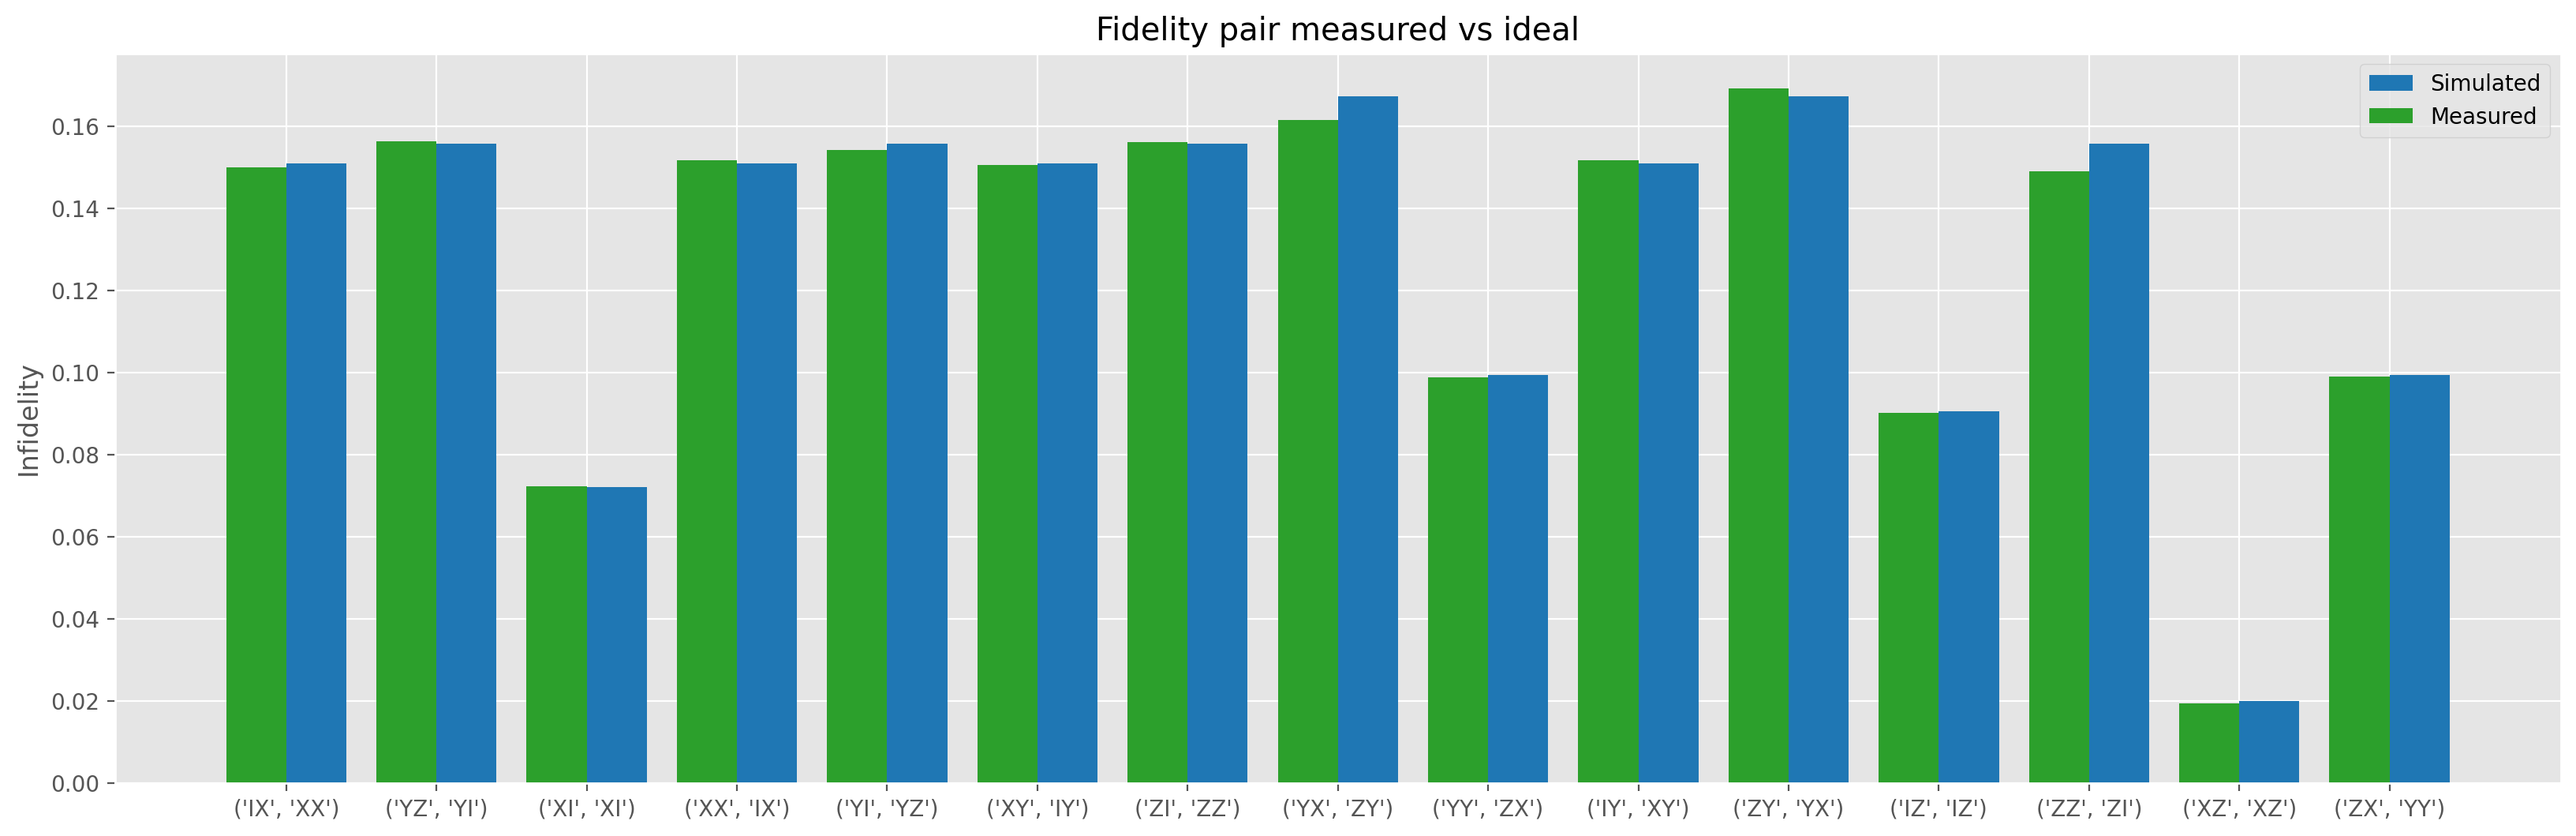

In [78]:
#Get list of measured and ideal fidelity pairs
terms = list([(t.pauli.to_label(),t.pair.to_label()) for t in layer._term_data.values()])
fidelities = list([1-dat.pair_fidelity**2 for dat in layer._term_data.values()])

ax = np.arange(0,len(terms))

#Plot
plt.figure(figsize=(20,6))
plt.bar(ax+.2, [
    (1-(1-real_errors[lab])*(1-real_errors[pair])) 
    for lab,pair in terms],.4, color='tab:blue')
plt.bar(ax-.2, fidelities, .4,color = 'tab:green')
plt.xticks(ax, terms)

#Plot title/legend
plt.title("Fidelity pair measured vs ideal")
plt.ylabel("Pauli term")
plt.ylabel("Infidelity")
plt.legend(['Simulated', 'Measured'])

#### Degeneracy-lifting measurements
The following plot shows the results of single fidelities determined through degeneracy-lifting measurements compared against the ideal fidelities.

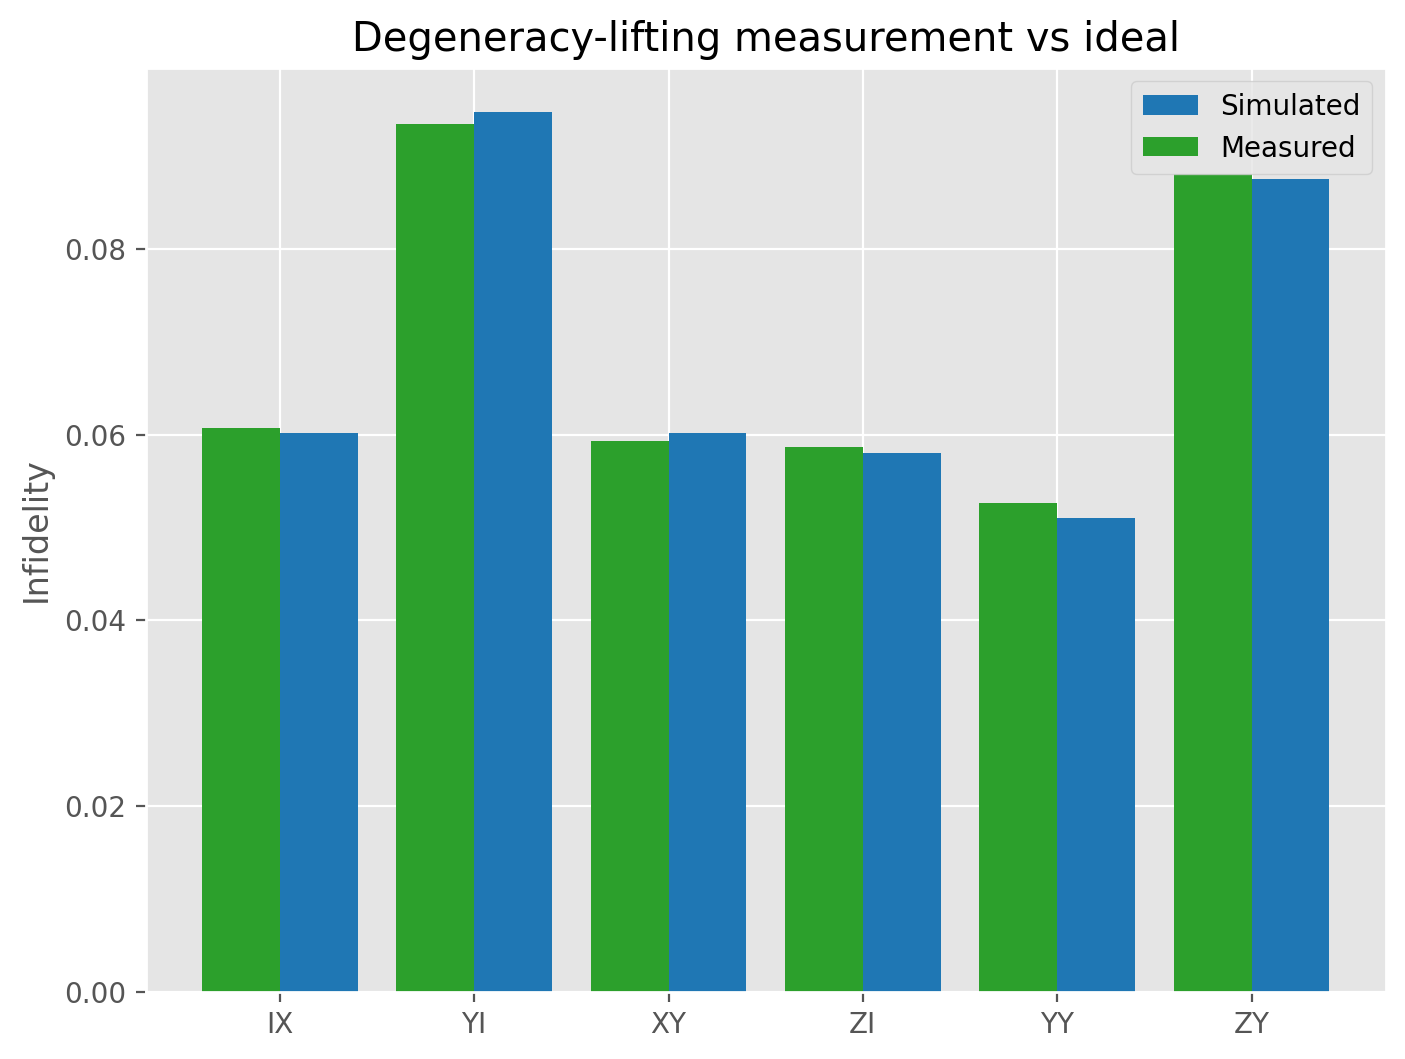

In [79]:
#Get results of single measurements and ideal fidelities
terms = [t for t in layer._term_data.values() if t.single_fidelity]
fidelities = [1-t.single_fidelity for t in terms]

ax = np.arange(len(terms))

plt.figure(figsize=(8,6))
plt.bar(ax+.2, [real_errors[t.pauli.pauli.to_label()] for t in terms],.4, color='tab:blue')
plt.bar(ax-.2, fidelities, .4,color = 'tab:green')
plt.xticks(ax, [t.pauli.to_label() for t in terms]);

plt.title("Degeneracy-lifting measurement vs ideal")
plt.ylabel("Pauli term")
plt.ylabel("Infidelity")
plt.legend(['Simulated', 'Measured'])

## Noise coefficients
As discussed in the tutorial notebook, the noise coefficients can be determined by a least-squares fitting algorithm. This next cell compares the results of the tomography to the model coefficients computed from the simulated Pauli fidelities.

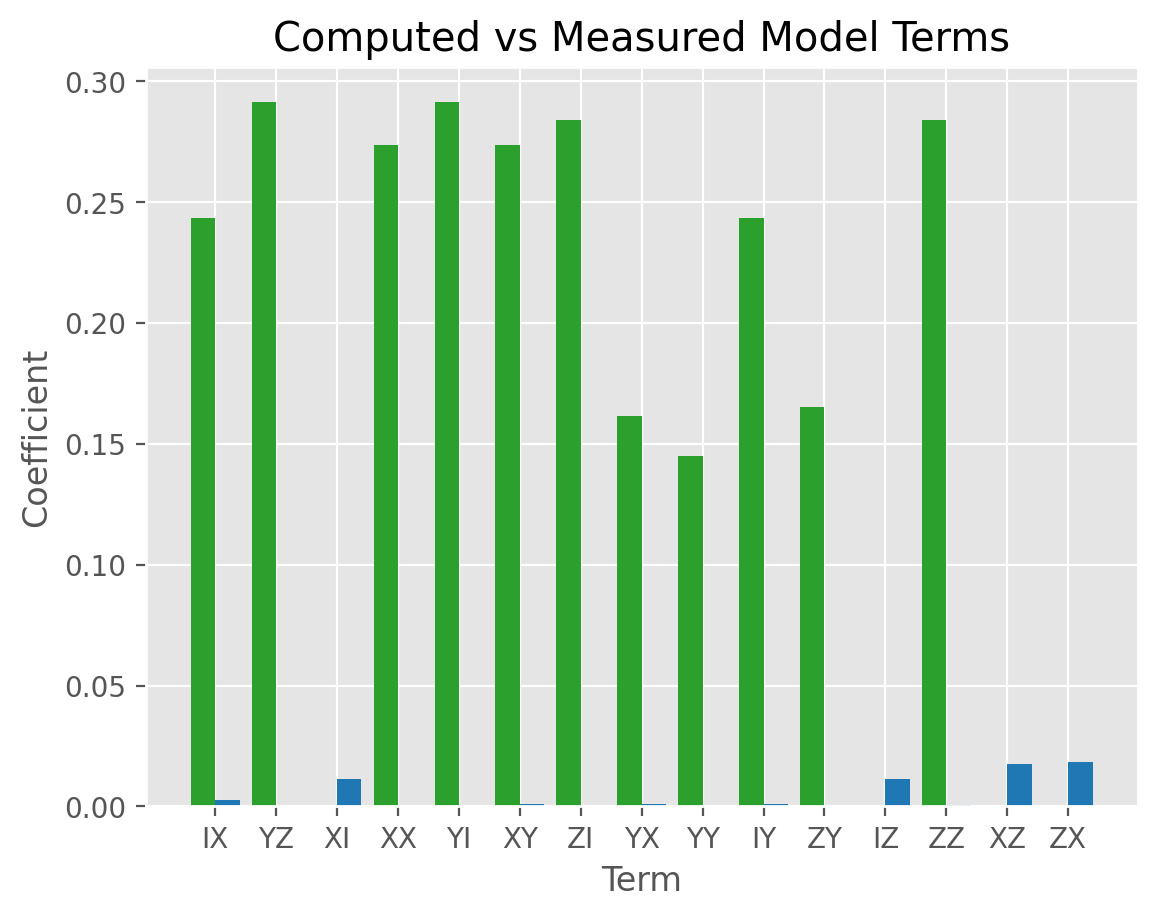

In [83]:
model_terms = layer._term_data #get a list of terms in the model

#List constructed based on the description in van den Berg et. Al
f1 = []
f2 = []
fidelities = []

#construct fidelities lists based on pair/single measurements
for key in model_terms.values():
    f1.append(key.pauli)
    fidelities.append(key.fidelity)
    if key.single_fidelity:
        f2.append(key.pair)
    else:
        f2.append(key.pauli)

#define symplectic inner product and construct M matrices
sprod = lambda a,b: int(not a.commutes(b))
M1 = [[sprod(a,b) for a in model_terms] for b in f1]
M2 = [[sprod(a,b) for a in model_terms] for b in f2]
for i in real_errors:
    if real_errors[i].real <= 0: 
        print(real_errors)
        real_errors[i]= -real_errors[i]
        #raise Exception("Measured a negativ number")
#Solve for the coefficients using the simulated fidelities
real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors[term.pauli.to_label()].real for term in f1]))

#Get a list of coefficients output by the tomography procedure in the same order
coeffs = dict(list(noisedataframe.noisemodels.values())[0].coeffs)
meas_coeffs = [coeffs[term] for term in f1]

#plot
ax = np.arange(len(model_terms))

plt.bar(ax+.2, meas_coeffs, .4, color='tab:blue')
plt.bar(ax-.2, real_coeffs, .4, color='tab:green')

plt.xticks(ax, [t.to_label() for t in model_terms]);
plt.title("Computed vs Measured Model Terms");
plt.xlabel("Term");
plt.ylabel("Coefficient");